<h1> 0. Import des packages, libraires, modules </h1>

<h2> 0.1. Pour rendre les fichiers excel du site VendéeGlobe exploitables </h2>

In [1]:
import os                                # Module OS pour diverses interfaces pour le sys. d'exploitation
import re                                # Module d'opérations à base d'expressions rationnelles
import shutil                            # Module High-level file operations
import tempfile                          # Module de génération de fichiers et répertoires temporaires
from fnmatch      import fnmatch         # Librairie de filtrage par motif des noms de fichiers UNIX
from os           import listdir         # Pour lister les fichiers et sous-dossiers existants dans un répertoire
from os.path      import isfile, join    # Manipulation des noms de répertoires communs
from zipfile      import ZipFile         # Manipulation des fichiers ZIP

<h2> 0.2. Pour Pré-traiter, traiter, et post-traiter les données </h2>

In [2]:
import cartopy as ctp                               # Pour manipuler les données géographiques
import datetime as dt                               # Pour manipuler les données temporelles
import matplotlib.pyplot as plt                     # Pour représenter les données
import numpy as np                                  # Pour manipuler les données
import pandas as pd                                 # Pour manipuler les données en forme de DataFrame
import requests                                     # Pour récupérer les données HTTP

from bs4 import BeautifulSoup                       # Pour exploiter les données d'un site internet à base de code HTML
from sklearn.metrics import r2_score                # 
from sklearn import preprocessing                   #
from sklearn.linear_model import LassoCV            #
from sklearn.linear_model import LinearRegression   # Pour études de régression linéaire

<h2>0.3. Pour optimiser le temps de traitement</h2>

In [3]:
import time
import threading

from tqdm.auto import tqdm

<h1>1. Initialisation</h1>

Le processus d'initialisation consiste en (après avoir effectuer les imports de packages, librairies, et modules) :
- La vérification de l'existance des dossiers de données d'entrées, tels:
>   - le dossier "DataRank_2021" contenant tous les fichiers Excel de la course (classement, la vitesse, la position,...)
>   - le dossier "DataSkipper_2021" contenant les caractéristiques techniques des skippers (longueur, largeur, tirant d'eau, ...)
- La vérification de l'existance de tous les fichiers contenant l'entièreté des données spécifiques (classement jour par jour, données techniques skipper par skipper)

Dans les cas où le dossier n'est pas créé, alors les fichiers de données ne sont pas non plus extraites. Alors, le programme va les charger.
Sinon, si les dossiers les dossiers sont complets, alors nous pouvons "sauter" le processus.

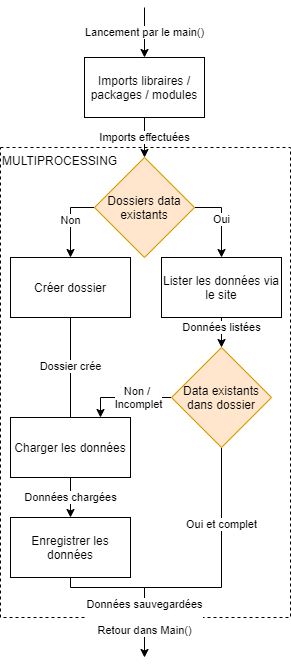

<h2>1.0. Définition des liens et répertoires</h2>

Ci-dessous, l'ensemble des liens internets essentiels pour l'étude

In [4]:
MainDir = os.getcwd()
DataRankDir = '\DataRank_2021'
DataSkipperDir = '\DataSkipper_2021'
RankURL = "https://www.vendeeglobe.org/fr/classement"
DLRankURL = "https://www.vendeeglobe.org/download-race-data/vendeeglobe_"
SkippersURL = "https://www.vendeeglobe.org/fr/glossaire"
RankFileType = ".xlsx"

<h2>1.1. Gestionnaire des dossiers data</h2>

Etant donné le nombre de fichier Excel de la course et le nombre de données techniques des skippers, il vaudrait mieux structurer répertoire en plusieurs sous-dossiers :
- DataRank_2021
- DataSkipper_2021

Afin de rendre le programme robuste, quelque soit le support informatique utilisé, il est nécessaire de vérifier que ces sous-dossiers existent. Sinon, il faudra les créer.

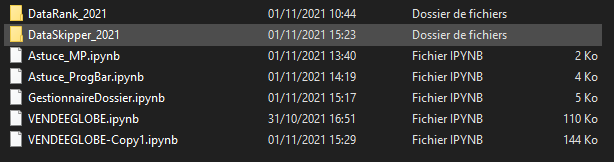

In [5]:
def CHECK_DATA_DIR(MainDir,DataType):
    if not os.path.exists(MainDir+DataType):
        os.mkdir(MainDir+DataType)
        ExistDir = False
    else :
        ExistDir = True
    print("Le répertoire '", DataType, "' exist : ", np.where(ExistDir==True, "OK", "NOK \nCréation du répertoire"))
    return ExistDir

<h2>1.2. Extractions des données (complets ou manquants)</h2>

<h3>1.2.1. Chargement des données de la course</h3>

><h4> Obtention d'une liste de fichiers Excel </h4>

Le script ci-dessous permet d'obtenir une liste des fichiers de données de course existants.
<br><u>Note :</u> L'option "Précédents classements" équivaut l'option "- 2021-03-05 08:00:00". Ce premier ne sera donc pas retenu dans la liste.

In [6]:
def GET_RANK_LIST (RankURL):
    soup = BeautifulSoup(requests.get(RankURL).content.decode("utf-8"))
    ListSoup = soup.findAll('option')
    RankList = []
    for iRankList in ListSoup:
        RankList.append(iRankList.text[2:])
    RankList = np.unique(RankList[1:-1])
    print ("Il y a ", len(RankList), "fichiers Excel de classement")
    return RankList

><h4>Conversion format des dates</h4>

Les dates mentionnés sur l'onglet "options" et à la fin du nom de fichier sont formatés différemment.
Pour automatiser le téléchargement, il faut redéfinir le format des dates.
Par cette même occasion, nous pouvons convertir ces dates en format AAAA-MM-JJ HH:MM:SS pour l'établissement des dataframes lors du traitement et post-traitement des données.

In [7]:
def CONVERT_TIME_FORMAT (InputDate):
    TimeList = []
    TableFileName = []
    for i in InputDate:
        TimeList.append(dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S"))
        TableFileName.append(dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%Y%m%d_%H%M%S"))
    return TimeList,TableFileName

><h4> Reconversion des fichiers Excel </h4>

Pandas et les autres modules ne semblent pas pouvoir ouvrir les fichiers directement téléchargés. Un collègue de la promotion IA a conçu un script permettant de rendre ces fichiers exploitables depuis ces modules.

In [8]:
def UPDATE_FORMAT(file_name, name_filter, change):
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)           
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)

><h4> Téléchargement du fichier excel </h4>

Le script ci-dessous effectue le téléchargement de tous les fichiers correspondants à la liste mentionnée précédemment.

In [9]:


def DWNLD_DAILY_RANK_FILE(DLRankURL, TFN, RankFileType, MainDir, DataDir):
    os.chdir(MainDir+DataDir)
    
    with tqdm(range(len(TFN)), desc = "Chargement des données Excel") as outer:
        for iTFN in TFN:
            resp = requests.get(DLRankURL+iTFN+RankFileType)
            #print("vendeeglobe_"+iTFN+RankFileType)
            with open("vendeeglobe_"+iTFN+RankFileType,'wb') as file:
                file.write(resp.content)
            UPDATEFORMAT("vendeeglobe_"+iTFN+RankFileType, name_filter='xl/styles.xml', change=lambda d: re.sub(b'xxid="\d*"', b"", d))
            outer.update()
    os.chdir(MainDir)

><h4>Vérification du téléchargement des données excel en intégralité</h4>

Le script ci-dessous permet de vérifier que les fichiers ont téléchargés en intégralité. Sinon, il va télécharger ceux qui manquent.

In [10]:
def CHECK_FILE_LIST(MainDir, DataRankDir, TFN):
    Directory = MainDir+DataRankDir
    FilesList = [f for f in listdir(Directory) if isfile(join(Directory, f))]
    #print(FilesList)
    ListToDownLoad = []
    for iTFN in TFN:
        if  not str("vendeeglobe_"+iTFN+".xlsx") in FilesList:
            ListToDownLoad.append(iTFN)
            pass
    return ListToDownLoad

><h4>Main - Programme de lancement</h4>

In [11]:
ExistDir = CHECK_DATA_DIR(MainDir,DataRankDir)
RankList = GET_RANK_LIST (RankURL)
TL,TFN = CONVERT_TIME_FORMAT(RankList)
if ExistDir == False :
    DWNLD_DAILY_RANK_FILE(DLRankURL, TFN, RankFileType, MainDir, DataRankDir)
else :
    ListToDownLoad = CHECK_FILE_LIST(MainDir, DataRankDir, TFN)
    if len(ListToDownLoad)!=0:
        DWNLD_DAILY_RANK_FILE(DLRankURL, ListToDownLoad, RankFileType, MainDir, DataRankDir)

Le répertoire ' \DataRank_2021 ' exist :  OK
Il y a  702 fichiers Excel de classement


<h3>1.2.2. Chargement des données techniques des skippers</h3>

In [12]:
""" OLD - CREATION D'UNE FONCTION DE RECUPERATION DE DONNEES SPECIFIQUES"""
"""def LIST_SOUP (SkippersURL, Dataparam, ikey):
    soup = BeautifulSoup(requests.get(SkippersURL).content.decode("utf-8"))
    ListSoup = soup.findAll(DataParam[ikey][0],
                            {DataParam[ikey][1]:
                             DataParam[ikey][2]})
    return ListSoup"""

""" Fonction remplacée par lambda LIST_SOUP"""

' Fonction remplacée par lambda LIST_SOUP'

In [13]:
def GEN_SEPCS_DF (SkippersURL):
    # Paramètres des types de données à extraire
    DataParam = {"BoatSpecs" : ['ul', "class", "boats-list__popup-specs-list"],
                 "BoatName" : ['h3',"class","boats-list__boat-name"],
                 "SkipperName" : ["span","class", "boats-list__skipper-name"]}
    # Fonction d'extraction de données techniques spécifiques (BoatSpecs, BoatName, SkipperName) sous forme de list
    LIST_SOUP = lambda SkippersURL, DataParam,ikey : BeautifulSoup(requests.get(SkippersURL).content.decode("utf-8"))\
    .findAll(DataParam[ikey][0],
             {DataParam[ikey][1]:
              DataParam[ikey][2]})
    
    # Création d'un DF Spécifications techniques du voilier vierge
    SpecsDF=pd.DataFrame()
    
    # Remplissage du DF
    for ikey in DataParam:
        ListSoup = LIST_SOUP (SkippersURL, DataParam, ikey)
        
        # Remplir d'abord les données techniques du voilier (Num. voile, Anciens nom, Architece, Chantier, Date lanc., Longueur,...)
        if ikey == list(DataParam.keys())[0]:
            i = 0
            for iul in ListSoup:
                idata,ivalue = np.transpose([string.split(' : ',1) for string in iul.text.split("\n")[1:-1]])
                SpecsDF = pd.concat([SpecsDF,pd.DataFrame([ivalue],columns = idata)],ignore_index=True)
                i+=1
        # Ajouter ensuite les colonnes Nom de voilier, et nom du marin; puis les mettre en premières colonnes
        else:
            SpecsDF[ikey] = [string.text for string in ListSoup]
            cols = SpecsDF.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            SpecsDF = SpecsDF[cols]
    
    # Homogénéisation des données
    SpecsDF[["Anciens noms du bateau", "Voile quille"]] = SpecsDF[["Anciens noms du bateau", "Voile quille"]].replace(np.nan,'')
    SpecsDF[["Nombre de dérives"]] = SpecsDF[["Nombre de dérives"]].replace(["foiler", "2 asymétriques"],['foils', "2"])
    '''SpecsDF[["Longueur", "Largeur", "Tirant d'eau", "Déplacement (poids)", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant"]] =\
        SpecsDF[["Longueur", "Largeur", "Tirant d'eau", "Déplacement (poids)", "Hauteur mât", "Surface de voiles au près", "Surface de voiles au portant"]]\
        .replace([" m²"," m2","m"," m", " t","t", " tonnes"],"")'''
    #SpecsDF['Longueur'] = SpecsDF['Longueur'].stack().str.replace(',','.').unstack()
    #res = re.findall('\d+', ' '.join(SpecsDF['Longueur']))
    #print(res)
    return SpecsDF


In [14]:
Specs_DF = GEN_SEPCS_DF(SkippersURL)
Specs_DF

,SkipperName,BoatName,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice AMEDEO,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,Romain ATTANASIO,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,Alexia BARRIER,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Yannick BESTAVEN,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,Jérémie BEYOU,CHARAL,08,,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
5,Arnaud BOISSIÈRES,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
6,Louis BURTON,BUREAU VALLEE 2,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
7,Didac COSTA,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,02 Février 2000,"18,28 m","5,30 m","4,50 m","8,9 t",2,26 m,acier,240 m2,470 m2
8,Manuel COUSIN,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,"18,28 m","5,80 m","4,50 m",9 t,2,"28,50",basculante sur vérin hydraulique,270 m2,560 m2
9,Clarisse CREMER,BANQUE POPULAIRE X,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,"18,28 m","5,70 m","4,5 m","7,7 t",2,29 m,acier forgé,340 m2,570 m2


<h1> 1. Pré-traitement des données </h1>

<h2>1.1. Ouverture du contenu de la page de classement</h2>

In [15]:
resp = requests.get("https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210305_080000.xlsx")
with open("vendeeglobe_20210305_080000.xlsx",'wb') as file:
            file.write(resp.content)

In [112]:
os.chdir(MainDir+DataRankDir)
df = pd.read_excel ("vendeeglobe_20210305_080000.xlsx", header=3)
df = df.rename(columns={'Unnamed: 0': 'Date'})
df["Date"]='2021/03/05 08:00:00'
print('Attention! Date en format str à convertir en format date')

Attention! Date en format str à convertir en format date


In [113]:
df["Date d'arrivée\nArrival date"] = df["Unnamed: 7"]
df.loc[1:,"Écarts\nGaps"] = df.loc[1:,"Unnamed: 13"]
df.loc[1:,"Unnamed: 14"] = df.loc[1:,"Unnamed: 15"]
df = df.drop(["Unnamed: 5","Unnamed: 6","Unnamed: 7", "Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 13", "Unnamed: 15"], 1)

C:\Users\alexa\AppData\Local\Temp/ipykernel_19700/2092352341.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(["Unnamed: 5","Unnamed: 6","Unnamed: 7", "Unnamed: 9", "Unnamed: 10", "Unnamed: 11", "Unnamed: 13", "Unnamed: 15"], 1)


In [114]:
df.head()

,Date,Rang\nRank,Nat. / Voile\nNat. / Sail,Skipper / Bateau\nSkipper / crew,Date d'arrivée\nArrival date,Temps de course\nRace time,Écarts\nGaps,Unnamed: 14,Sur l'ortho\nOver ortho,Unnamed: 17,►,Sur le fond\nOver ground,Unnamed: 20
0,2021/03/05 08:00:00,NaN,NaN,NaN,NaN,NaN,Au premier\nTo first,Au précédent\nTo previous,Vitesse\nSpeed,Distance\nDistance,NaN,Vitesse\nSpeed,Distance\nDistance
1,2021/03/05 08:00:00,1\nARV,\nFRA 17,Yannick Bestaven\nMaître Coq IV,28/01/2021 04:19:46 FR,80j 03h 44min 46s\n-10h 15min 00s,NaN,NaN,12.6 kts,24365.7 nm,117.3 %,14.8 kts,28583.8 nm
2,2021/03/05 08:00:00,2\nARV,\nFRA 79,Charlie Dalin\nAPIVIA,27/01/2021 20:35:47 FR,80j 06h 15min 47s\n,02h 31min 01s,02h 31min 01s,12.6 kts,24365.7 nm,119.6 %,15.1 kts,29135.0 nm
3,2021/03/05 08:00:00,3\nARV,\nFRA 18,Louis Burton\nBureau Vallée 2,28/01/2021 00:45:12 FR,80j 10h 25min 12s\n,06h 40min 26s,04h 09min 25s,12.6 kts,24365.7 nm,117.6 %,14.8 kts,28650.0 nm
4,2021/03/05 08:00:00,4\nARV,\nFRA 01,Jean Le Cam\nYes we Cam !,28/01/2021 20:19:55 FR,80j 13h 44min 55s\n-16h 15min 00s,10h 00min 09s,03h 19min 43s,12.5 kts,24365.7 nm,112.9 %,14.1 kts,27501.5 nm


In [18]:
df.isnull().all()

Unnamed: 0      True
Unnamed: 1     False
Unnamed: 2     False
Unnamed: 3     False
Unnamed: 4     False
Unnamed: 5      True
Unnamed: 6      True
Unnamed: 7     False
Unnamed: 8     False
Unnamed: 9      True
Unnamed: 10     True
Unnamed: 11     True
Unnamed: 12    False
Unnamed: 13    False
Unnamed: 14    False
Unnamed: 15    False
Unnamed: 16    False
Unnamed: 17    False
Unnamed: 18    False
Unnamed: 19    False
Unnamed: 20    False
dtype: bool

In [19]:
df = df.dropna(axis = 'columns',
         how = 'all')

df = df.dropna(axis = 'index',
         how = 'all')

In [20]:
df[:-4]

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 7,Unnamed: 8,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
1,Classement du vendredi 05 mars 2021 à 09h00 FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Rang\nRank,Nat. / Voile\nNat. / Sail,Skipper / Bateau\nSkipper / crew,Date d'arrivée\nArrival date,NaN,Temps de course\nRace time,Écarts\nGaps,NaN,NaN,NaN,Sur l'ortho\nOver ortho,NaN,►,Sur le fond\nOver ground,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,Au premier\nTo first,NaN,Au précédent\nTo previous,NaN,Vitesse\nSpeed,Distance\nDistance,NaN,Vitesse\nSpeed,Distance\nDistance
4,1\nARV,\nFRA 17,Yannick Bestaven\nMaître Coq IV,NaN,28/01/2021 04:19:46 FR,80j 03h 44min 46s\n-10h 15min 00s,NaN,NaN,NaN,NaN,12.6 kts,24365.7 nm,117.3 %,14.8 kts,28583.8 nm
5,2\nARV,\nFRA 79,Charlie Dalin\nAPIVIA,NaN,27/01/2021 20:35:47 FR,80j 06h 15min 47s\n,NaN,02h 31min 01s,NaN,02h 31min 01s,12.6 kts,24365.7 nm,119.6 %,15.1 kts,29135.0 nm
6,3\nARV,\nFRA 18,Louis Burton\nBureau Vallée 2,NaN,28/01/2021 00:45:12 FR,80j 10h 25min 12s\n,NaN,06h 40min 26s,NaN,04h 09min 25s,12.6 kts,24365.7 nm,117.6 %,14.8 kts,28650.0 nm
7,4\nARV,\nFRA 01,Jean Le Cam\nYes we Cam !,NaN,28/01/2021 20:19:55 FR,80j 13h 44min 55s\n-16h 15min 00s,NaN,10h 00min 09s,NaN,03h 19min 43s,12.5 kts,24365.7 nm,112.9 %,14.1 kts,27501.5 nm
8,5\nARV,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,NaN,28/01/2021 11:19:45 FR,80j 14h 59min 45s\n-06h 00min 00s,NaN,11h 14min 59s,NaN,01h 14min 50s,12.6 kts,24365.7 nm,116.8 %,14.7 kts,28448.5 nm
9,6\nARV,\nFRA 59,Thomas Ruyant\nLinkedOut,NaN,28/01/2021 05:42:01 FR,80j 15h 22min 01s\n,NaN,11h 37min 15s,NaN,22min 16s,12.6 kts,24365.7 nm,119.7 %,15.1 kts,29175.5 nm
10,7\nARV,\nFRA 1000,Damien Seguin\nGroupe APICIL,NaN,28/01/2021 12:18:20 FR,80j 21h 58min 20s\n,NaN,18h 13min 34s,NaN,06h 36min 19s,12.5 kts,24365.7 nm,112.9 %,14.2 kts,27512.3 nm


In [36]:
CONVERT_TIME_FORMAT("20210305_080000")

ValueError: time data '2' does not match format '%Y-%m-%d %H:%M:%S'

In [ ]:
def CONVERT_TIME_FORMAT (InputDate):
    TimeList = []
    TableFileName = []
    for i in InputDate:
        TimeList.append(dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S"))
        TableFileName.append(dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").strftime("%Y%m%d_%H%M%S"))
    return TimeList,TableFileName

In [37]:
RankList

array(['2020-11-08 14:00:00', '2020-11-08 15:00:00',
       '2020-11-08 17:00:00', '2020-11-08 21:00:00',
       '2020-11-09 04:00:00', '2020-11-09 08:00:00',
       '2020-11-09 11:00:00', '2020-11-09 14:00:00',
       '2020-11-09 17:00:00', '2020-11-09 21:00:00',
       '2020-11-10 04:00:00', '2020-11-10 08:00:00',
       '2020-11-10 11:00:00', '2020-11-10 14:00:00',
       '2020-11-10 17:00:00', '2020-11-10 21:00:00',
       '2020-11-11 04:00:00', '2020-11-11 08:00:00',
       '2020-11-11 11:00:00', '2020-11-11 14:00:00',
       '2020-11-11 17:00:00', '2020-11-11 21:00:00',
       '2020-11-12 04:00:00', '2020-11-12 08:00:00',
       '2020-11-12 11:00:00', '2020-11-12 14:00:00',
       '2020-11-12 17:00:00', '2020-11-12 21:00:00',
       '2020-11-13 04:00:00', '2020-11-13 08:00:00',
       '2020-11-13 11:00:00', '2020-11-13 14:00:00',
       '2020-11-13 17:00:00', '2020-11-13 21:00:00',
       '2020-11-14 04:00:00', '2020-11-14 08:00:00',
       '2020-11-14 11:00:00', '2020-11-14 14:0

In [39]:
TL

[datetime.datetime(2020, 11, 8, 14, 0),
 datetime.datetime(2020, 11, 8, 15, 0),
 datetime.datetime(2020, 11, 8, 17, 0),
 datetime.datetime(2020, 11, 8, 21, 0),
 datetime.datetime(2020, 11, 9, 4, 0),
 datetime.datetime(2020, 11, 9, 8, 0),
 datetime.datetime(2020, 11, 9, 11, 0),
 datetime.datetime(2020, 11, 9, 14, 0),
 datetime.datetime(2020, 11, 9, 17, 0),
 datetime.datetime(2020, 11, 9, 21, 0),
 datetime.datetime(2020, 11, 10, 4, 0),
 datetime.datetime(2020, 11, 10, 8, 0),
 datetime.datetime(2020, 11, 10, 11, 0),
 datetime.datetime(2020, 11, 10, 14, 0),
 datetime.datetime(2020, 11, 10, 17, 0),
 datetime.datetime(2020, 11, 10, 21, 0),
 datetime.datetime(2020, 11, 11, 4, 0),
 datetime.datetime(2020, 11, 11, 8, 0),
 datetime.datetime(2020, 11, 11, 11, 0),
 datetime.datetime(2020, 11, 11, 14, 0),
 datetime.datetime(2020, 11, 11, 17, 0),
 datetime.datetime(2020, 11, 11, 21, 0),
 datetime.datetime(2020, 11, 12, 4, 0),
 datetime.datetime(2020, 11, 12, 8, 0),
 datetime.datetime(2020, 11, 12, 1